# Chapter 09 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import matplotlib.pyplot as plt
import mlba
import numpy as np
import pandas as pd
import scipy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
%matplotlib inline

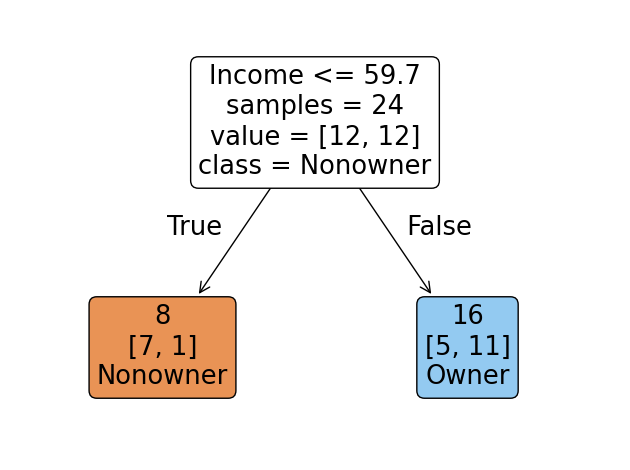

In [3]:
mower_df = mlba.load_data('RidingMowers.csv')
# use max_depth to control tree size (None = full tree)
classTree = DecisionTreeClassifier(random_state=0, max_depth=1)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
plot_tree(classTree, feature_names=mower_df.columns[:2],
          label='root', class_names=classTree.classes_,
          impurity=False, filled=True, rounded=True)
plt.tight_layout()
plt.show()

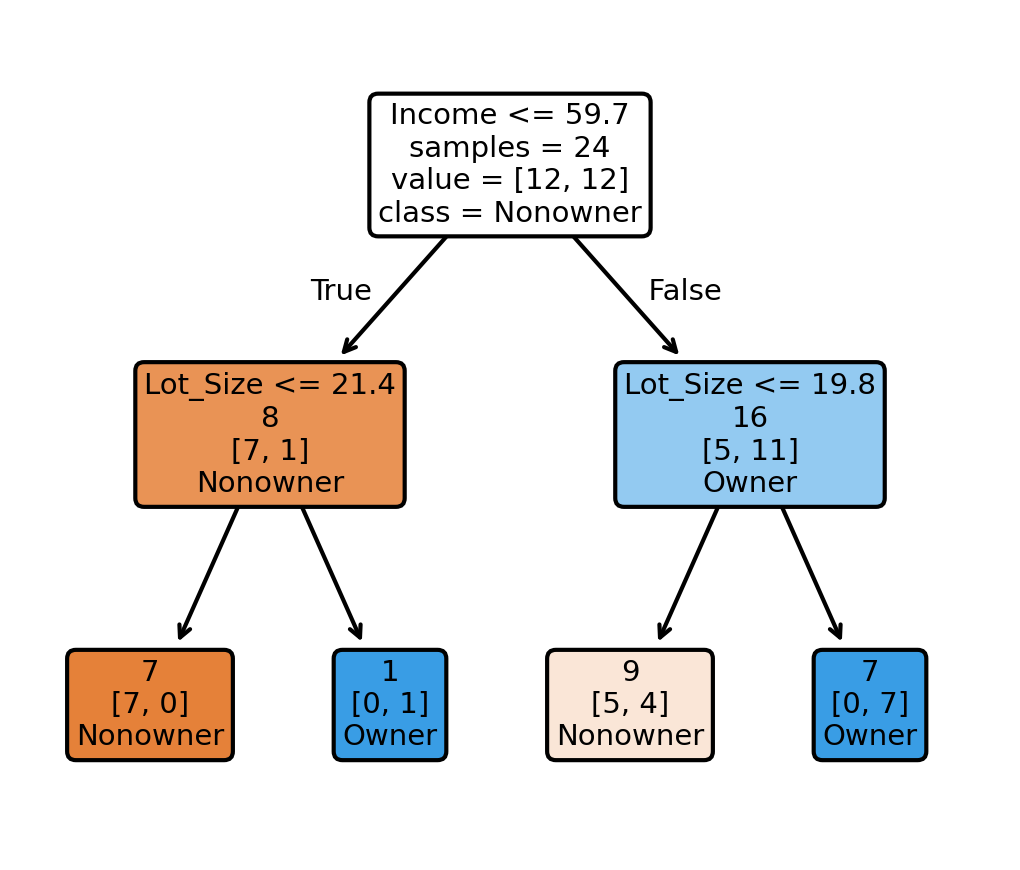

In [4]:
classTree = DecisionTreeClassifier(random_state=0, max_depth=2)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
plt.figure(figsize=[3.5, 3], dpi=300)
plot_tree(classTree, feature_names=mower_df.columns[:2],
          label='root', class_names=classTree.classes_,
          impurity=False, filled=True, rounded=True, fontsize=7)
plt.tight_layout()
plt.show()

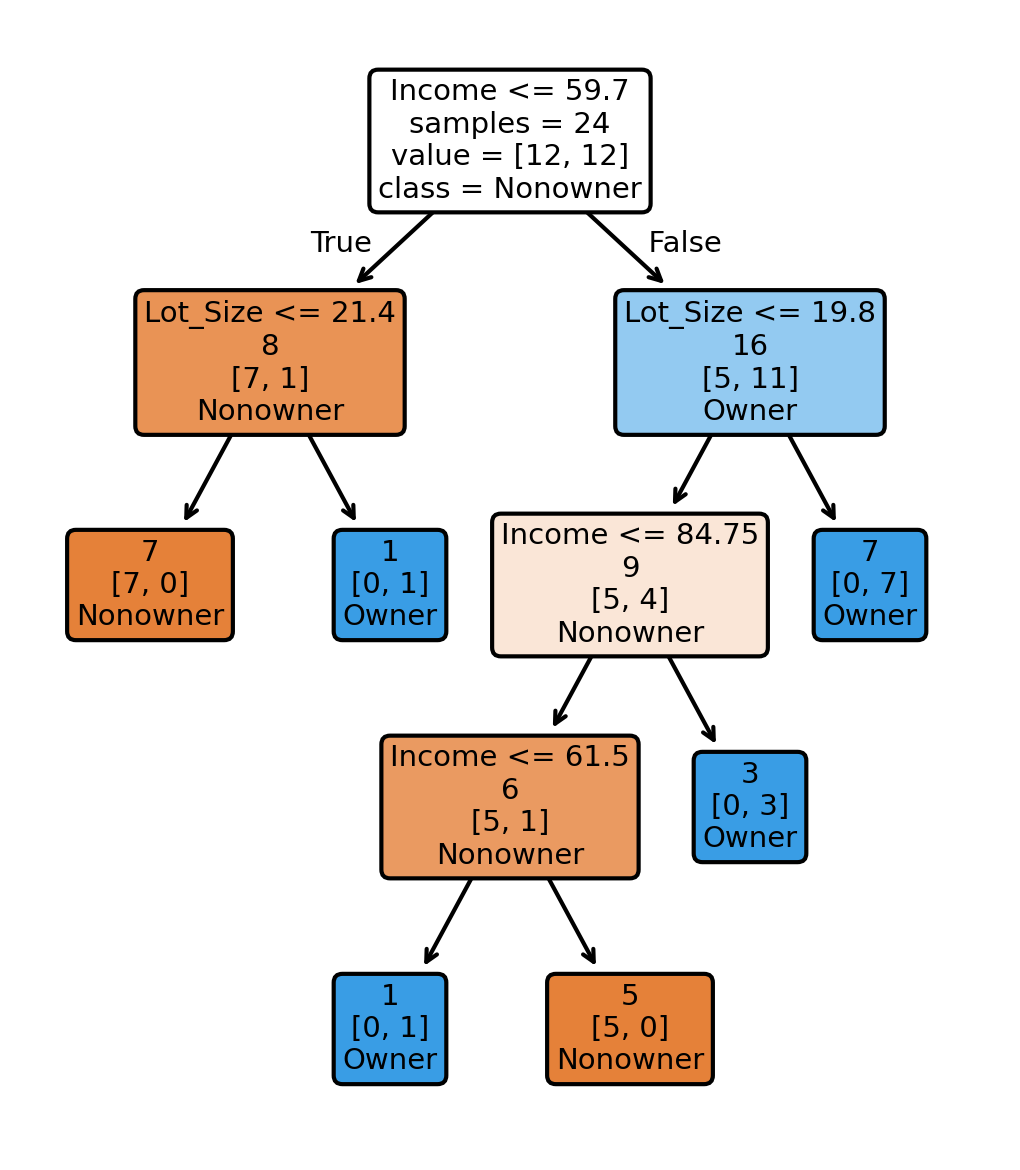

In [5]:
classTree = DecisionTreeClassifier(random_state=0)
classTree.fit(mower_df.drop(columns=['Ownership']), mower_df['Ownership'])
plt.figure(figsize=[3.5, 4], dpi=300)
plot_tree(classTree, feature_names=mower_df.columns[:2],
          label='root', class_names=classTree.classes_,
          impurity=False, filled=True, rounded=True, fontsize=7)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.tree import export_text
print(export_text(classTree, feature_names=mower_df.columns[:2], show_weights=True))

|--- Income <= 59.70
|   |--- Lot_Size <= 21.40
|   |   |--- weights: [7.00, 0.00] class: Nonowner
|   |--- Lot_Size >  21.40
|   |   |--- weights: [0.00, 1.00] class: Owner
|--- Income >  59.70
|   |--- Lot_Size <= 19.80
|   |   |--- Income <= 84.75
|   |   |   |--- Income <= 61.50
|   |   |   |   |--- weights: [0.00, 1.00] class: Owner
|   |   |   |--- Income >  61.50
|   |   |   |   |--- weights: [5.00, 0.00] class: Nonowner
|   |   |--- Income >  84.75
|   |   |   |--- weights: [0.00, 3.00] class: Owner
|   |--- Lot_Size >  19.80
|   |   |--- weights: [0.00, 7.00] class: Owner



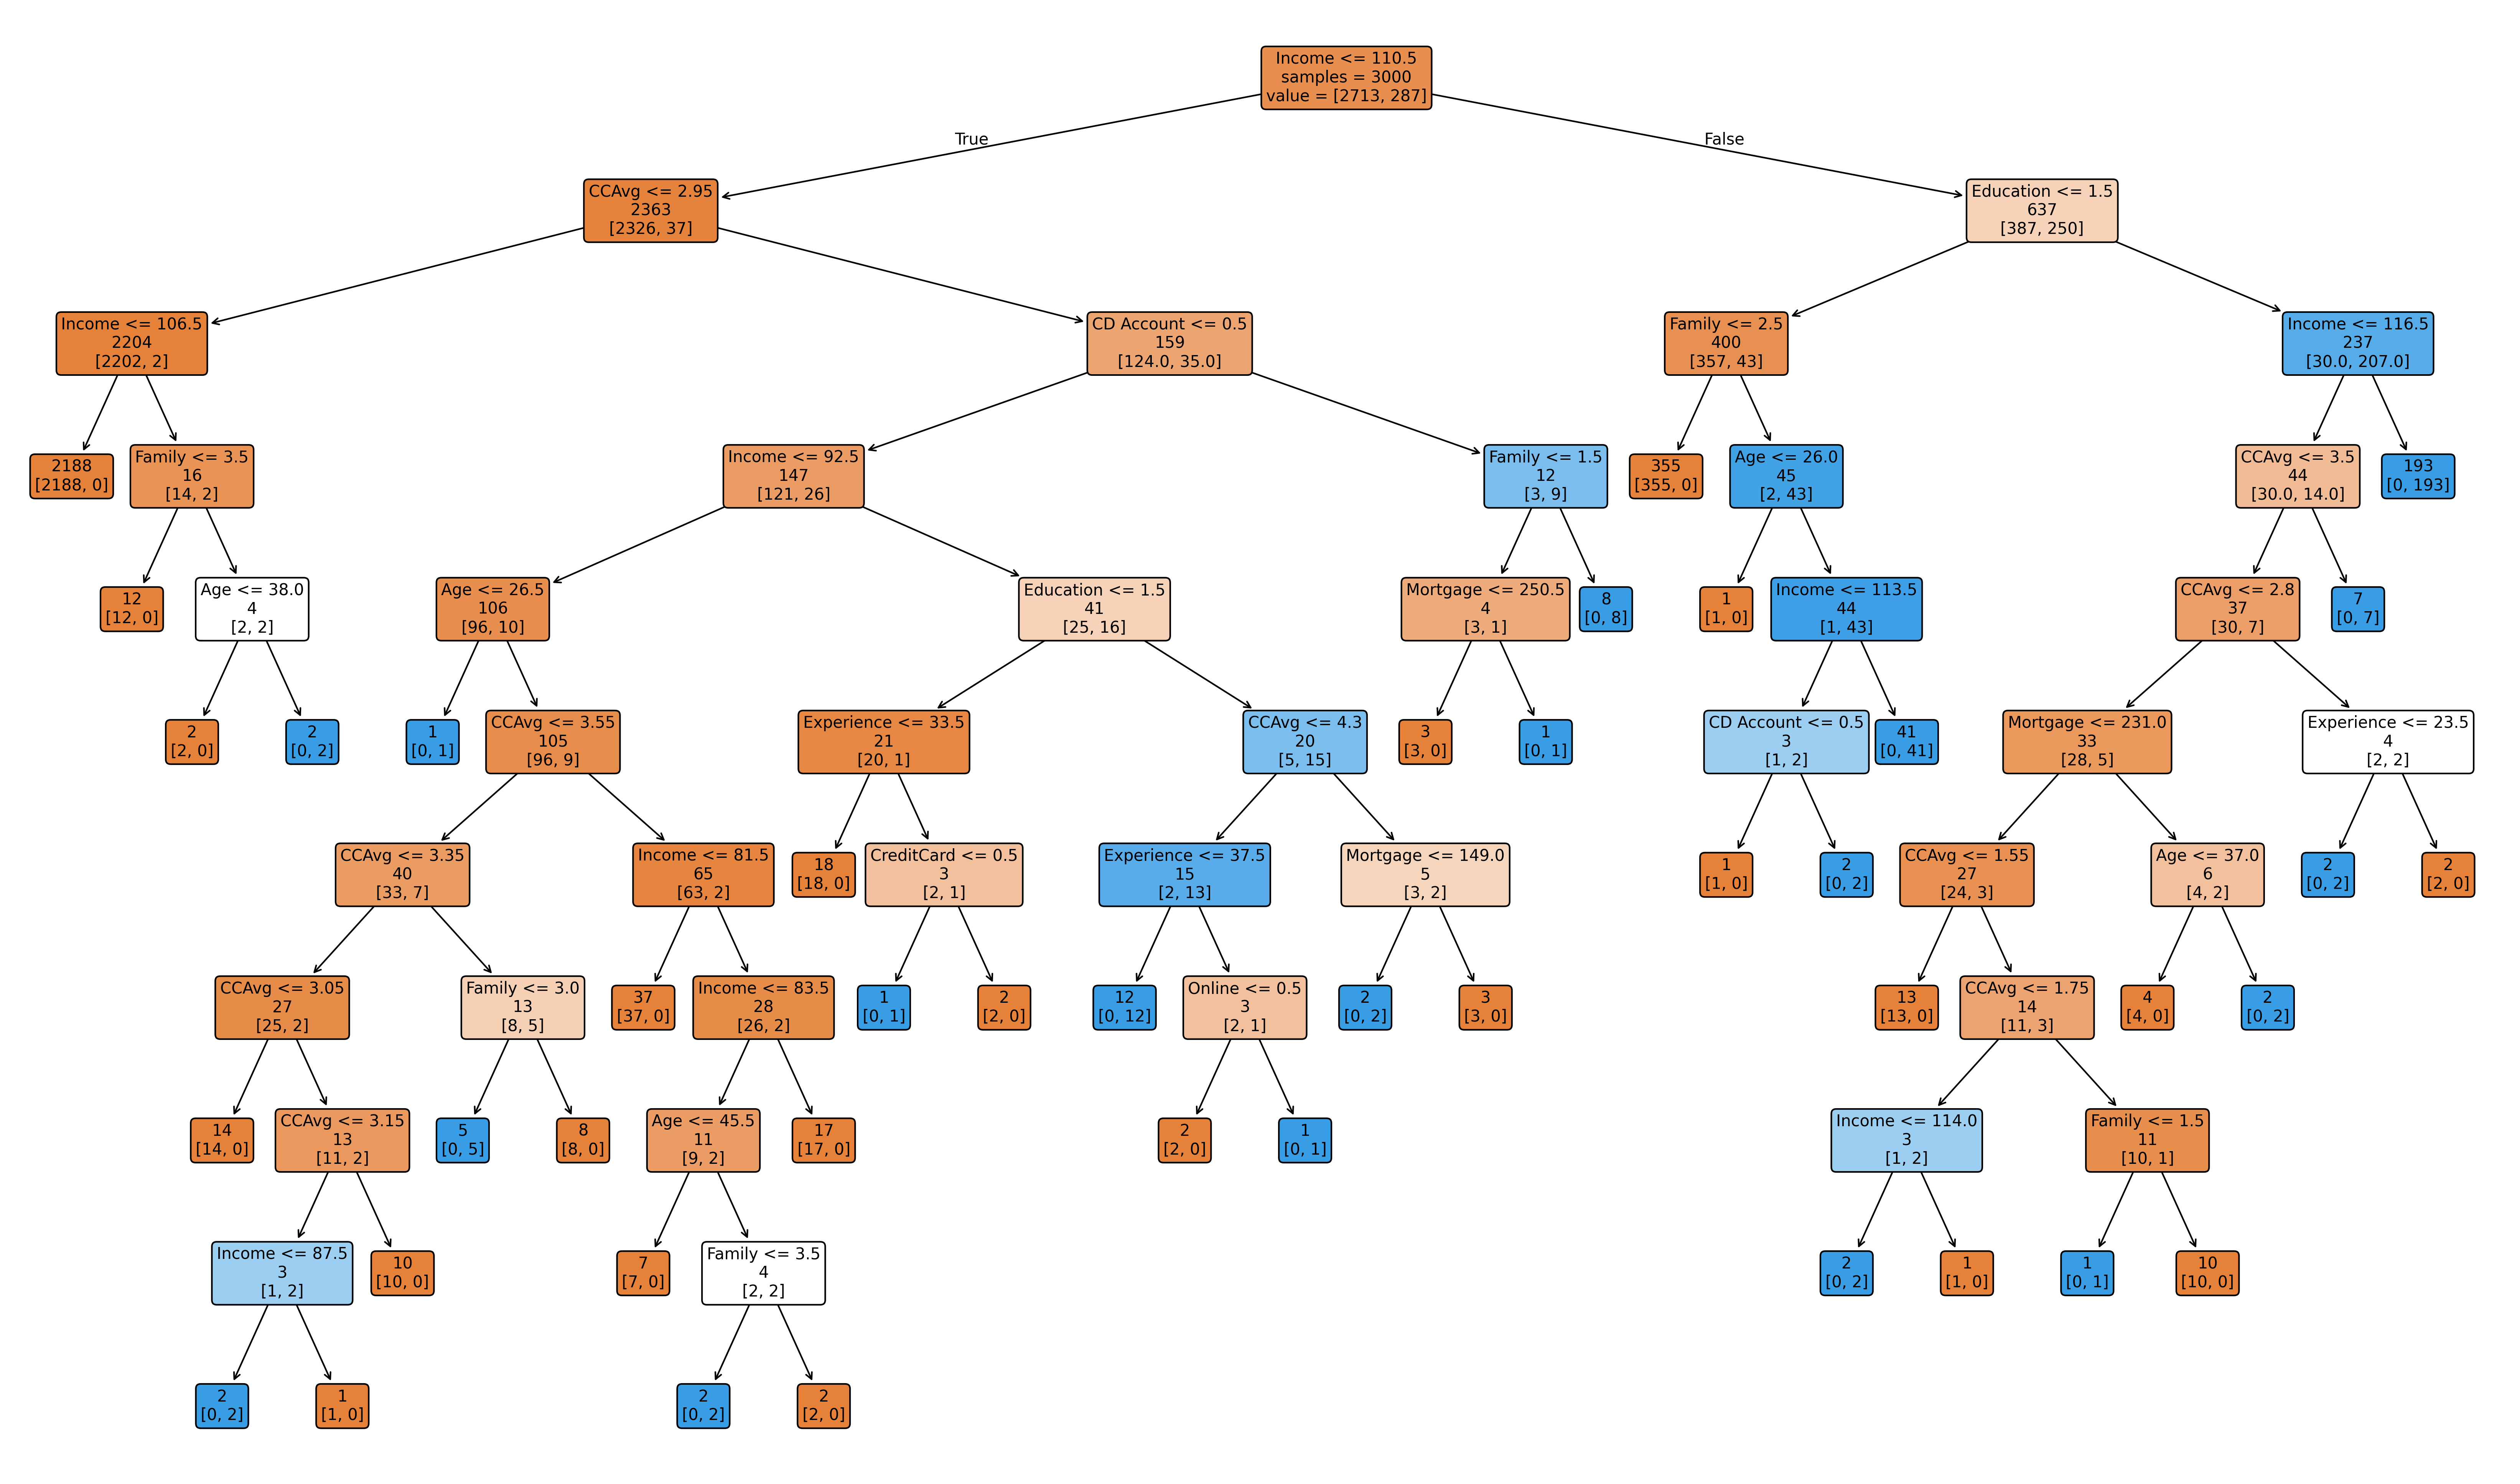

In [7]:
bank_df = mlba.load_data('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, holdout_X, train_y, holdout_y = train_test_split(X, y, test_size=0.4, random_state=1)

fullClassTree = DecisionTreeClassifier(random_state=1)
fullClassTree.fit(train_X, train_y)
plt.figure(figsize=[22, 13], dpi=300)
plot_tree(fullClassTree, feature_names=train_X.columns, label='root',
          impurity=False, filled=True, rounded=True, fontsize=10)
plt.tight_layout()
plt.show()

In [8]:
mlba.classificationSummary(y_true=train_y, y_pred=fullClassTree.predict(train_X))
mlba.classificationSummary(y_true=holdout_y, y_pred=fullClassTree.predict(holdout_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2713    0
     1    0  287
Confusion Matrix (Accuracy 0.9790)

       Prediction
Actual    0    1
     0 1790   17
     1   25  168


In [9]:
treeClassifier = DecisionTreeClassifier(random_state=1)

scores = cross_val_score(treeClassifier, train_X, train_y, cv=5)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])

Accuracy scores of each fold:  ['0.988', '0.973', '0.993', '0.982', '0.993']


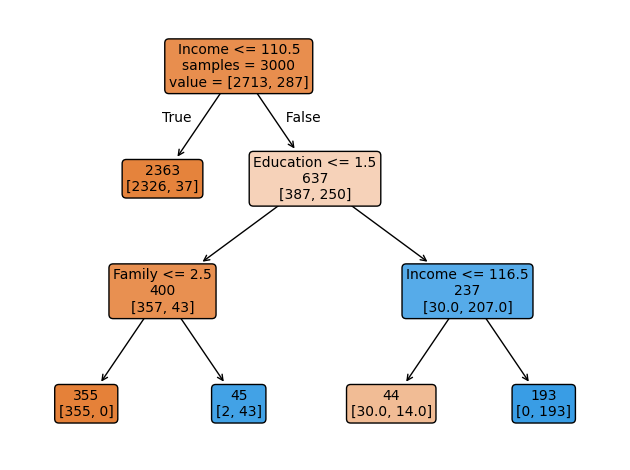

In [10]:
smallClassTree = DecisionTreeClassifier(max_depth=30, min_samples_split=20,
                        min_impurity_decrease=0.01, random_state=1)
smallClassTree.fit(train_X, train_y)

plot_tree(smallClassTree, feature_names=train_X.columns, label='root',
          impurity=False, filled=True, rounded=True, fontsize=10)
plt.tight_layout()
plt.show()

In [11]:
mlba.classificationSummary(y_true=train_y, y_pred=smallClassTree.predict(train_X))
mlba.classificationSummary(y_true=holdout_y, y_pred=smallClassTree.predict(holdout_X))

Confusion Matrix (Accuracy 0.9823)

       Prediction
Actual    0    1
     0 2711    2
     1   51  236
Confusion Matrix (Accuracy 0.9770)

       Prediction
Actual    0    1
     0 1804    3
     1   43  150


In [12]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [20, 40, 60, 80, 100],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5,
                          n_jobs=-1)  # n_jobs=-1 will utilize all available CPUs
gridSearch.fit(train_X, train_y)
print(f'Initial score: {gridSearch.best_score_:.4f}')
print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 16)),  # 14 values
    'min_samples_split': list(range(10, 22)), # 11 values
    'min_impurity_decrease': [0.0003, 0.0005, 0.0007], # 3 values
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5,
                          n_jobs=-1)
gridSearch.fit(train_X, train_y)
print(f'Improved score: {gridSearch.best_score_:.4f}')
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Initial score: 0.9877
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.0005, 'min_samples_split': 20}
Improved score: 0.9883
Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.0003, 'min_samples_split': 20}


/Users/petergedeck/git/Wiley-MLBA-Python-2e/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


 Evaluating performance

In [13]:
# fine-tuned tree: training
mlba.classificationSummary(y_true=train_y, y_pred=bestClassTree.predict(train_X))

Confusion Matrix (Accuracy 0.9907)

       Prediction
Actual    0    1
     0 2704    9
     1   19  268


In [14]:
# fine-tuned tree: holdout
mlba.classificationSummary(y_true=holdout_y, y_pred=bestClassTree.predict(holdout_X))

Confusion Matrix (Accuracy 0.9825)

       Prediction
Actual    0    1
     0 1793   14
     1   21  172


 Plotting tree

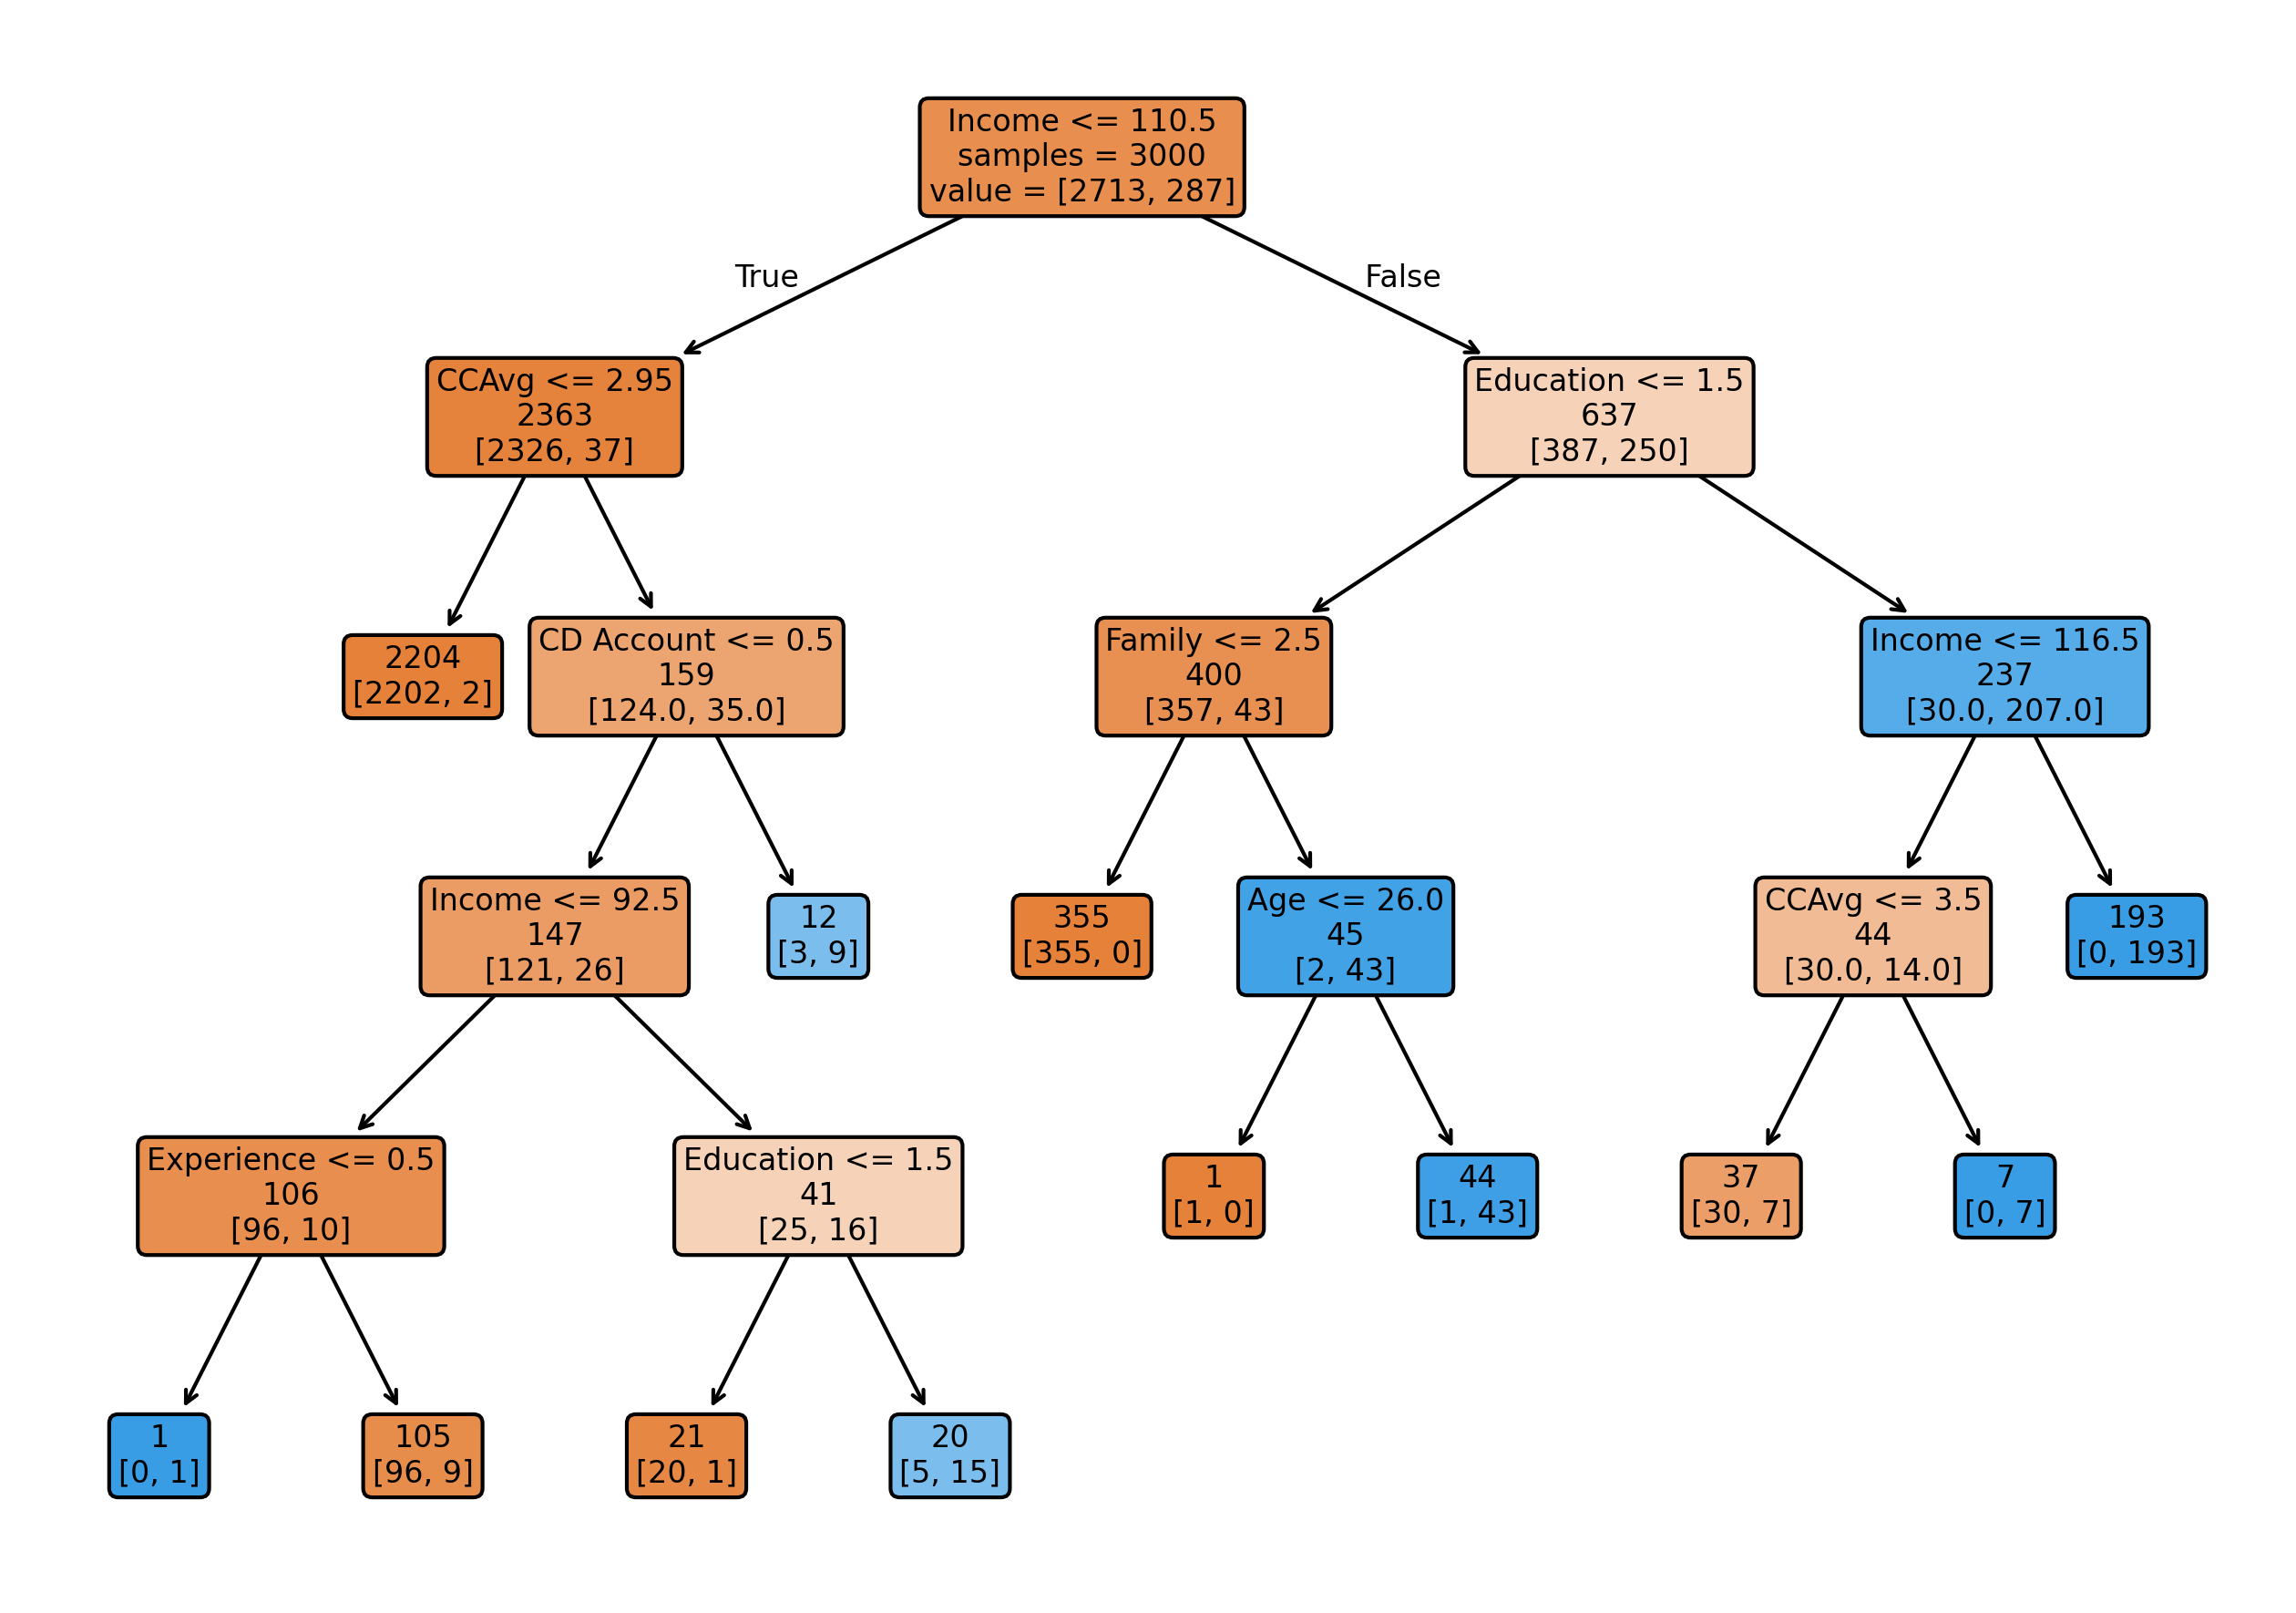

In [15]:
plt.figure(figsize=[8.5, 6], dpi=300)
plot_tree(bestClassTree, feature_names=train_X.columns, label='root',
          impurity=False, filled=True, rounded=True, fontsize=8)
plt.tight_layout()
plt.show()

In [16]:
toyotaCorolla_df = mlba.load_data('ToyotaCorolla.csv').iloc[:1000,:]
toyotaCorolla_df = toyotaCorolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})

predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC',
              'Doors', 'Tax', 'Weight']
outcome = 'Price'

X = pd.get_dummies(toyotaCorolla_df[predictors], drop_first=True)
y = toyotaCorolla_df[outcome]

train_X, holdout_X, train_y, holdout_y = train_test_split(X, y, test_size=0.4, random_state=1)

# user randomized search to find optimized tree
param_dist = {
    'max_depth': list(range(1, 25)),
    'min_impurity_decrease': scipy.stats.expon(scale=1),
    'min_samples_split': list(range(2, 50)),
}
randSearch = RandomizedSearchCV(DecisionTreeRegressor(), param_dist, cv=5,
                                n_jobs=-1, n_iter=100, random_state=1)
randSearch.fit(train_X, train_y)
print('Best parameters: ', randSearch.best_params_)

regTree = randSearch.best_estimator_

print(pd.DataFrame({
    'training': mlba.regressionMetrics(y_true=train_y, y_pred=regTree.predict(train_X)),
    'holdout': mlba.regressionMetrics(y_true=holdout_y, y_pred=regTree.predict(holdout_X)),
}).transpose().round(3))

Best parameters:  {'max_depth': 6, 'min_impurity_decrease': 0.6014829269986204, 'min_samples_split': 14}
             ME      RMSE       MAE    MPE   MAPE
training   0.00  1054.903   764.644 -0.803  6.809
holdout   55.91  1553.718  1023.344 -1.338  9.213


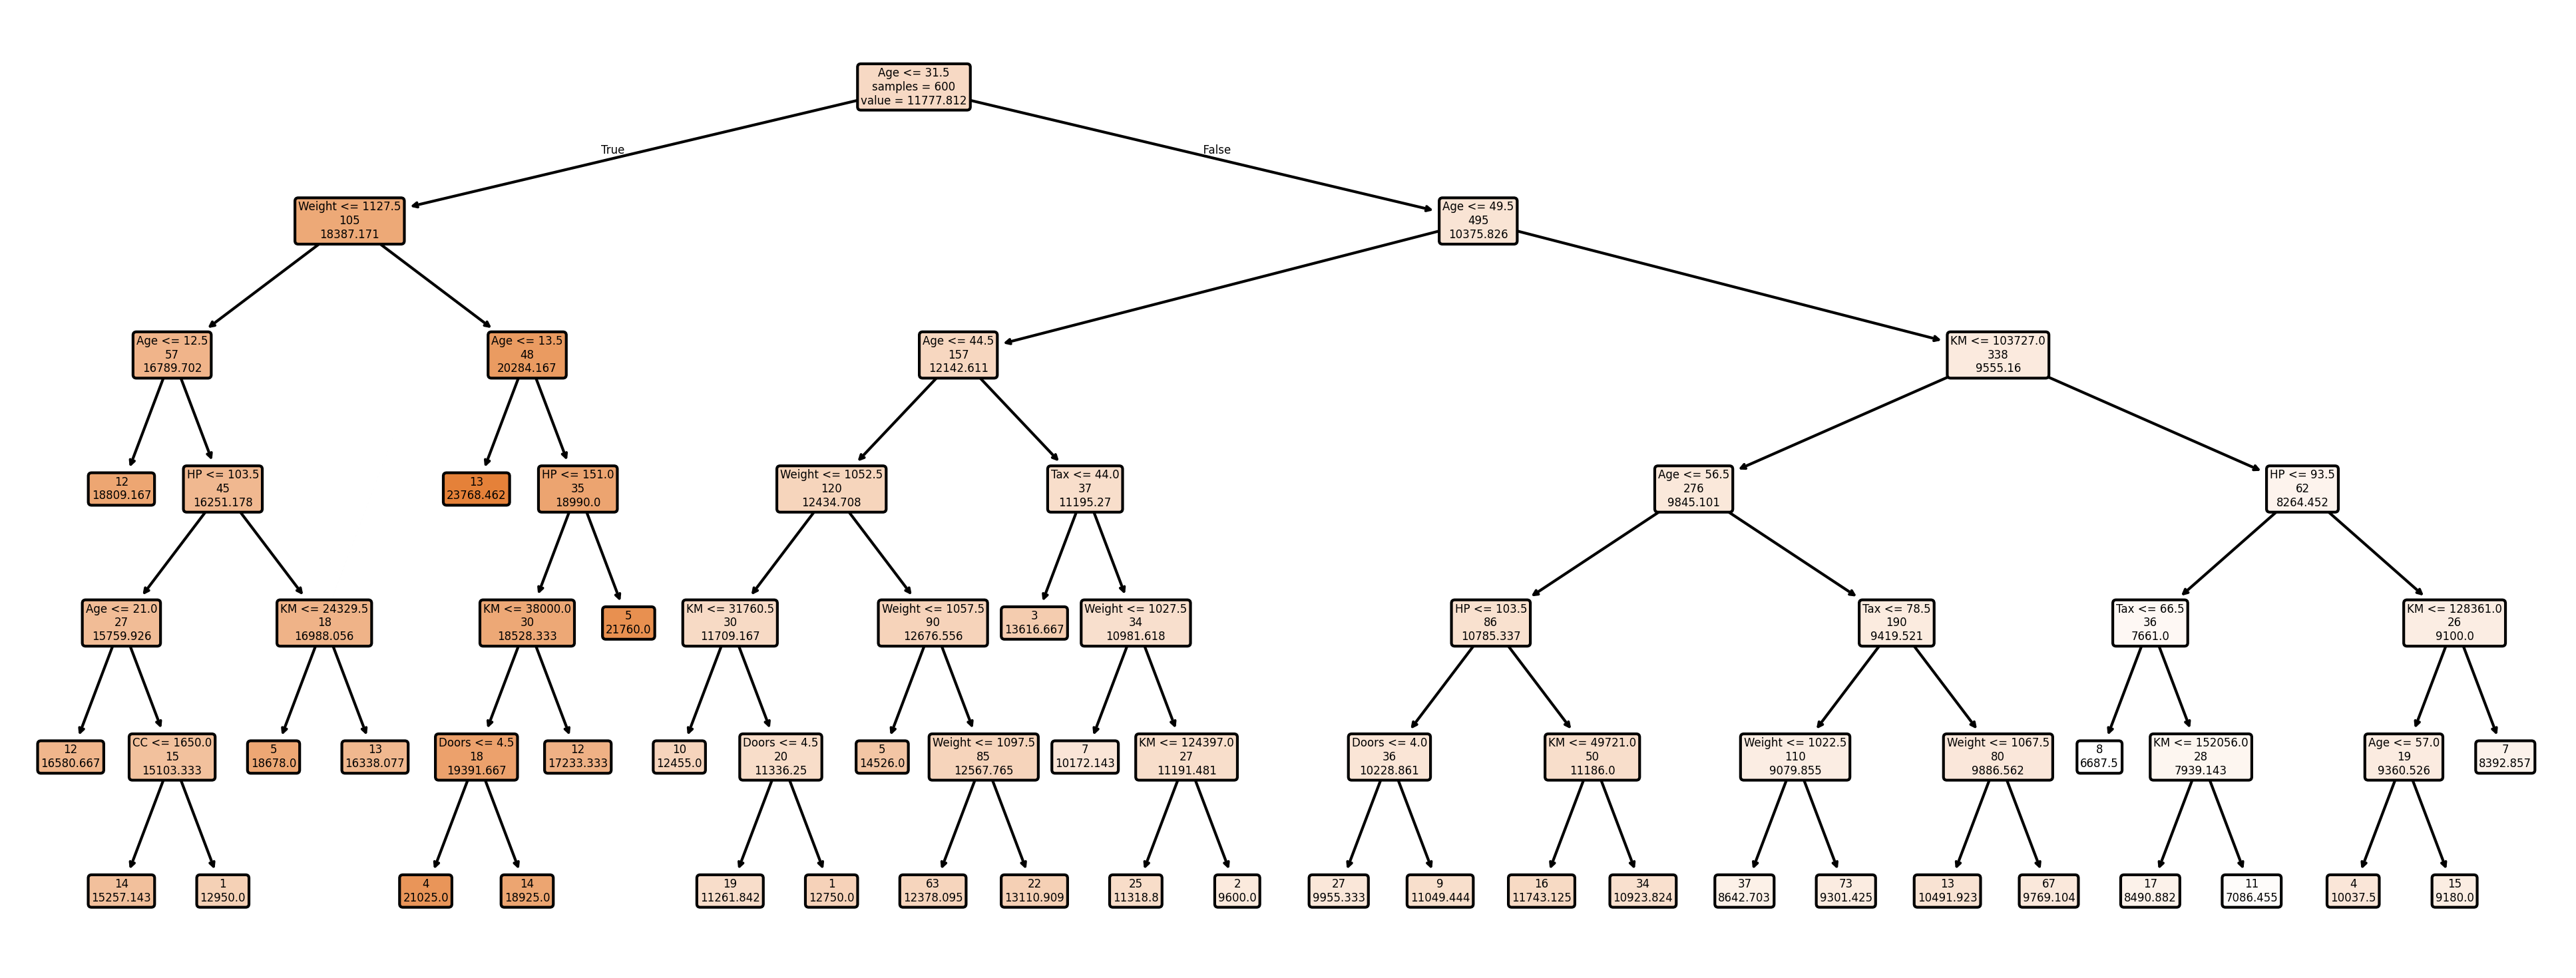

In [17]:
plt.figure(figsize=[13, 5], dpi=300)
plot_tree(regTree, feature_names=train_X.columns, label='root',
          impurity=False, filled=True, rounded=True, fontsize=4)
plt.tight_layout()
plt.show()

 
The figure shown in the book was created using the `export_graphviz` function from the `sklearn.tree` module. It requires the `graphviz` package to be installed. We wrapped it into the `mlba.plotDecisionTree` function. There are other packages to visualize trees, such as `dtreeviz`.

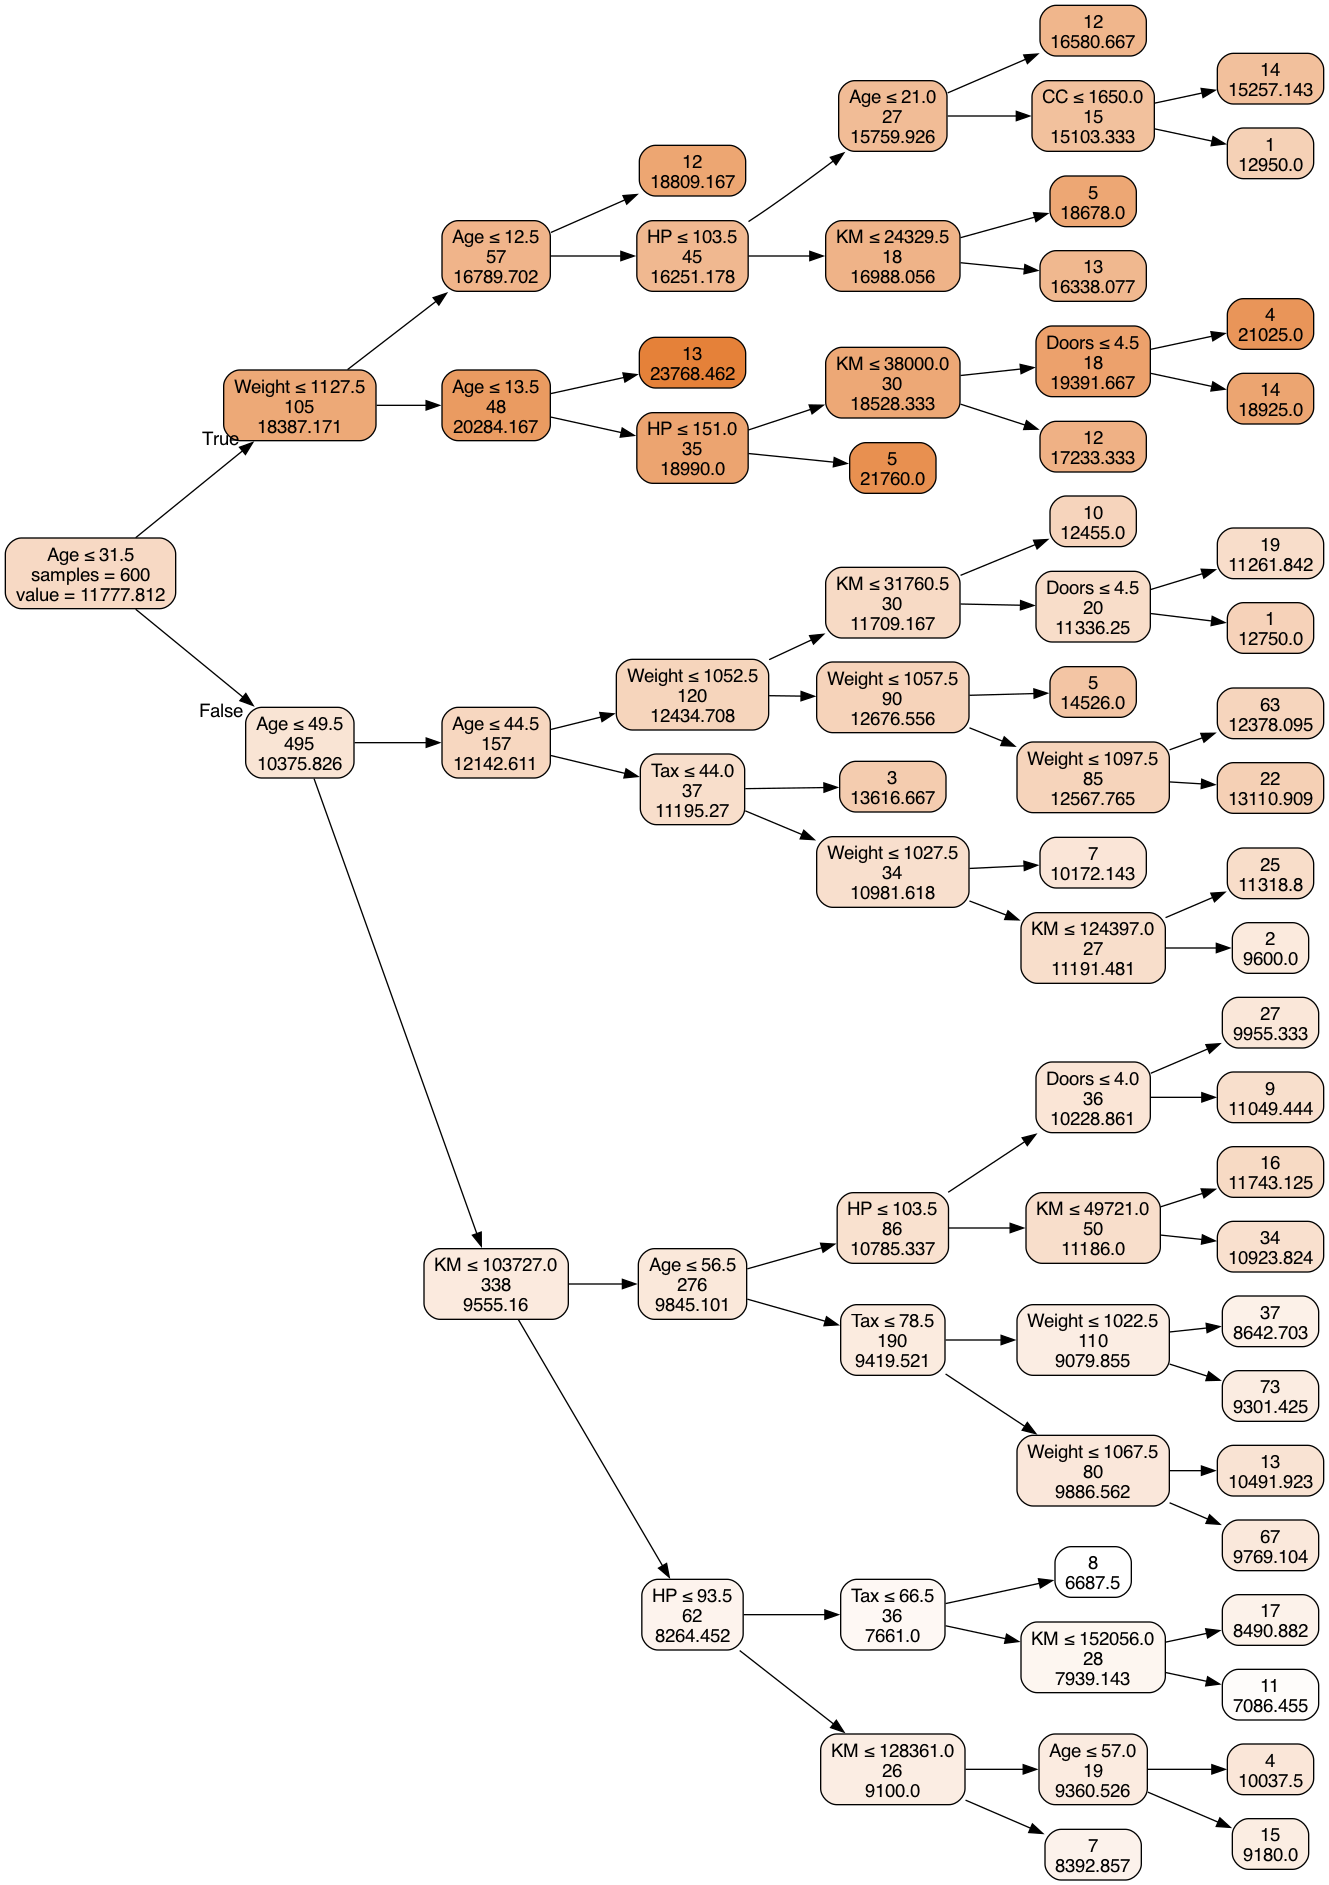

In [18]:
try:
    display(mlba.plotDecisionTree(regTree, feature_names=train_X.columns,
                                rotate=True, pdfFile=figures_dir / 'RT-tree-toyota-rotate.pdf'))
except Exception:
    print('The tree could not be plotted, install the required packages.')

In [19]:
bank_df = mlba.load_data('UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, holdout_X, train_y, holdout_y = train_test_split(X, y, test_size=0.4, random_state=1)

rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

# variable (feature) importance plot
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

               feature  importance       std
7   Securities Account    0.003882  0.004752
9               Online    0.006406  0.005354
10          CreditCard    0.007642  0.006951
6             Mortgage    0.034209  0.023448
1           Experience    0.035575  0.016021
0                  Age    0.036275  0.015869
8           CD Account    0.057934  0.043198
3               Family    0.111388  0.053174
4                CCAvg    0.171907  0.102980
5            Education    0.200715  0.100976
2               Income    0.334067  0.129097


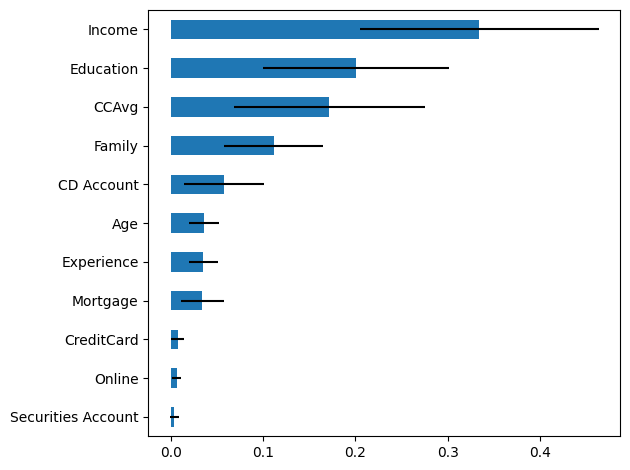

In [20]:
ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [21]:
# confusion matrix for holdout set
mlba.classificationSummary(y_true=holdout_y, y_pred=rf.predict(holdout_X))

Confusion Matrix (Accuracy 0.9820)

       Prediction
Actual    0    1
     0 1803    4
     1   32  161


In [22]:
boost = xgb.XGBClassifier()
boost.fit(train_X, train_y)
mlba.classificationSummary(y_true=holdout_y, y_pred=boost.predict(holdout_X))

Confusion Matrix (Accuracy 0.9830)

       Prediction
Actual    0    1
     0 1800    7
     1   27  166


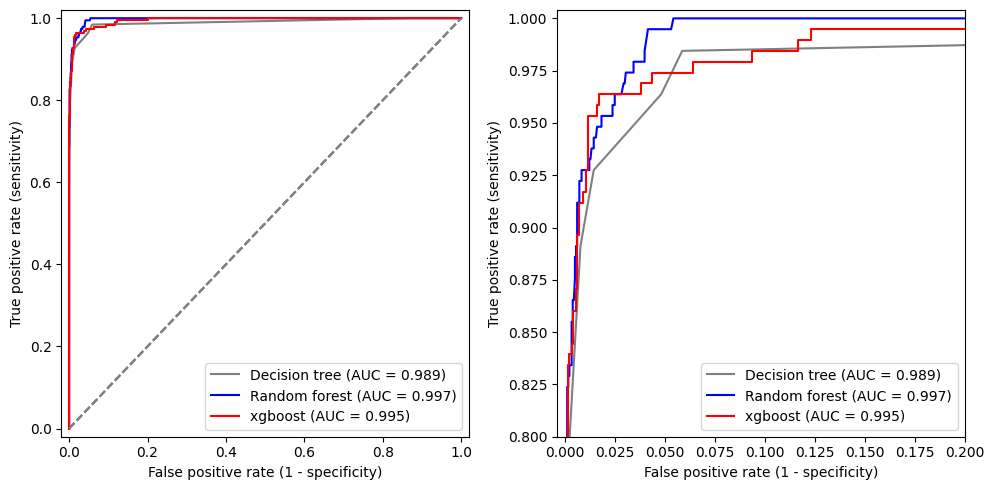

In [23]:
def plot_roc_curve(model, X, y, model_name, pos_label, *, color, axes):
    fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1], pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    for ax in axes:
        ax.plot(fpr, tpr, color=color, label=f'{model_name} (AUC = {roc_auc:0.3f})')
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlabel('False positive rate (1 - specificity)')
        ax.set_ylabel('True positive rate (sensitivity)')
        ax.legend(loc="lower right")
    axes[0].set_xlim([-0.02, 1.02])
    axes[0].set_ylim([-0.02, 1.02])
    axes[1].set_xlim([-0.004, 0.2])
    axes[1].set_ylim([0.8, 1.004])
    return ax

fig, axes = plt.subplots(ncols=2, figsize=[10, 5])
plot_roc_curve(bestClassTree, holdout_X, holdout_y, 'Decision tree', 1, color='gray',
               axes=axes)
plot_roc_curve(rf, holdout_X, holdout_y, 'Random forest', 1, color='blue', axes=axes)
plot_roc_curve(boost, holdout_X, holdout_y, 'xgboost', 1, color='red', axes=axes)
plt.tight_layout()
plt.show()

Confusion Matrix (Accuracy 0.9830)

       Prediction
Actual    0    1
     0 1796   11
     1   23  170


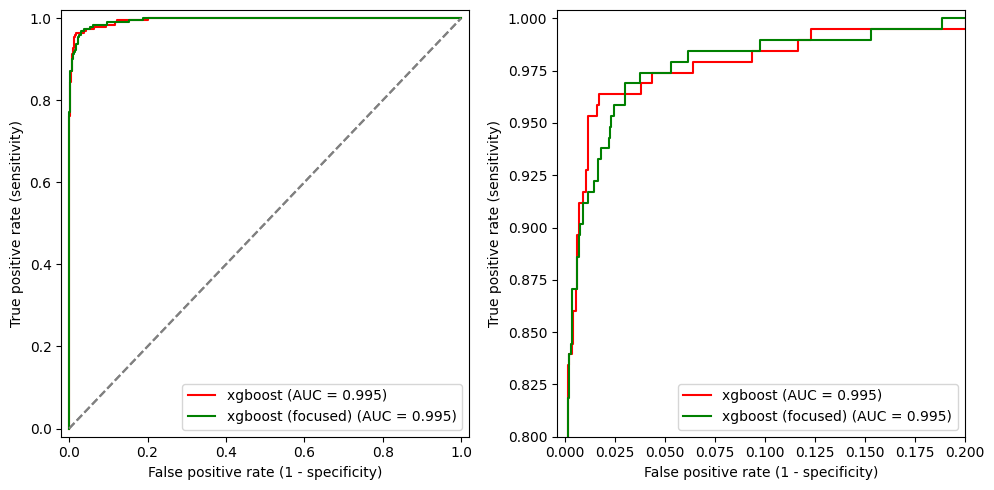

In [24]:
boost_focused = xgb.XGBClassifier(scale_pos_weight=10)
boost_focused.fit(train_X, train_y)
mlba.classificationSummary(y_true=holdout_y, y_pred=boost_focused.predict(holdout_X))

fig, axes = plt.subplots(ncols=2, figsize=[10, 5])
plot_roc_curve(boost, holdout_X, holdout_y, 'xgboost', 1, color='red', axes=axes)
plot_roc_curve(boost_focused, holdout_X, holdout_y, 'xgboost (focused)', 1,
               color='green', axes=axes)
plt.tight_layout()
plt.show()

 
  Figures demonstrating construction of a classification tree

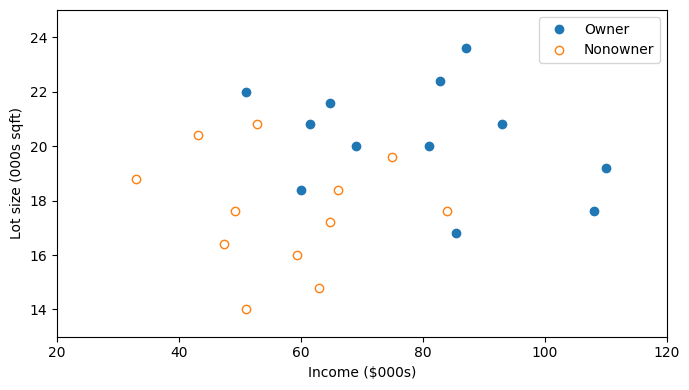

In [25]:
def basePlot(ax):
    mower_df.loc[mower_df.Ownership=='Owner'].plot(x='Income', y='Lot_Size', style='o',
                                                markerfacecolor='C0', markeredgecolor='C0',
                                                ax=ax, zorder=100)
    mower_df.loc[mower_df.Ownership=='Nonowner'].plot(x='Income', y='Lot_Size', style='o',
                                                    markerfacecolor='none', markeredgecolor='C1',
                                                    ax=ax, zorder=100)
    ax.legend(["Owner", "Nonowner"])
    ax.set_xlim(20, 120)
    ax.set_ylim(13, 25)
    ax.set_xlabel('Income ($000s)')
    ax.set_ylabel('Lot size (000s sqft)')
    return ax

fig, ax = plt.subplots(figsize=(7, 4))
ax = basePlot(ax)
plt.tight_layout()
plt.show()

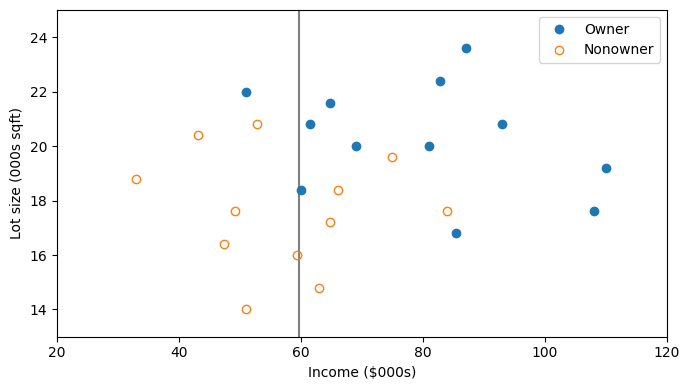

In [26]:
fig, ax = plt.subplots(figsize=(7, 4))
ax = basePlot(ax)
x0 = 59.7
ax.plot((x0, x0), (25, 13), color='grey')
plt.tight_layout()
plt.show()

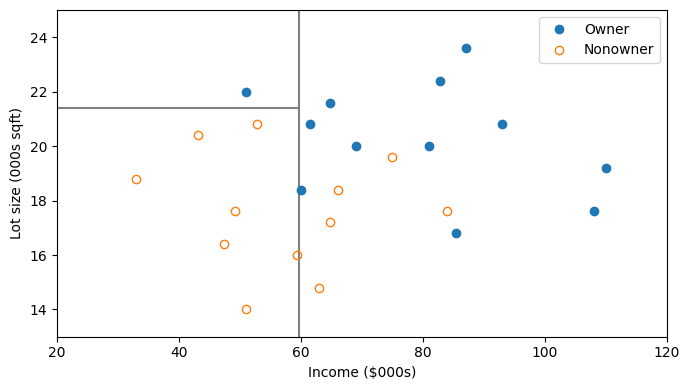

In [27]:
fig, ax = plt.subplots(figsize=(7, 4))
ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
plt.tight_layout()
plt.show()

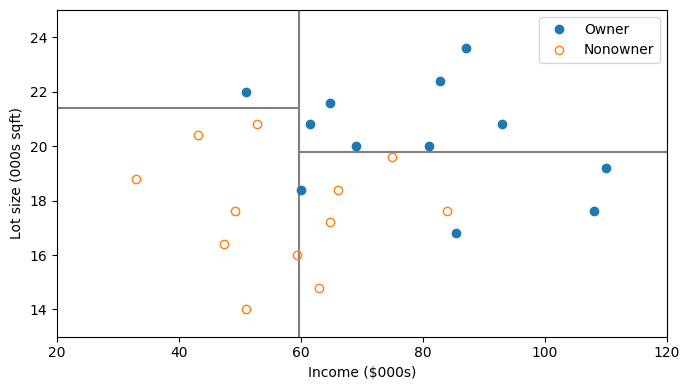

In [28]:
fig, ax = plt.subplots(figsize=(7, 4))
ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
y2 = 19.8
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
ax.plot((x0, 120), (y2, y2), color='grey')
plt.tight_layout()
plt.show()

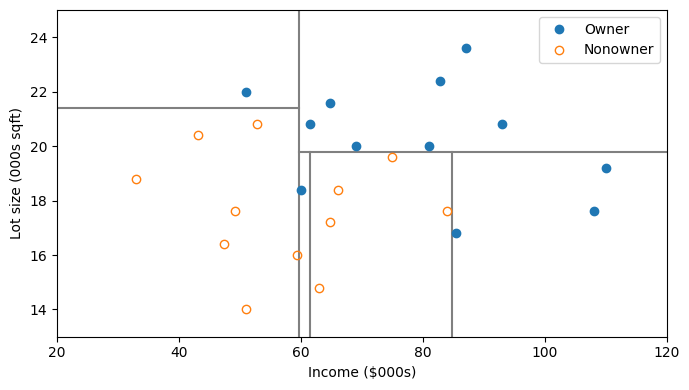

In [29]:
fig, ax = plt.subplots(figsize=(7, 4))
ax = basePlot(ax)
x0 = 59.7
y1 = 21.4
y2 = 19.8
x3 = 84.75
x4 = 61.5
ax.plot((x0, x0), (25, 13), color='grey')
ax.plot((20, x0), (y1, y1), color='grey')
ax.plot((x0, 120), (y2, y2), color='grey')
ax.plot((x3, x3), (13, y2), color='grey')
ax.plot((x4, x4), (13, y2), color='grey')
plt.tight_layout()
plt.show()